In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#taxi zone shapefile for joining kmeans results:

zones = gpd.read_file(os.getcwd()+"/shapefiles/"+'taxi_zones.shp')

#raw data shapefiles:

yelp = gpd.read_file(os.getcwd()+"/shapefiles/"+'final_yelp_spatial.shp')
taxi = gpd.read_file(os.getcwd()+"/shapefiles/"+'total.shp')
seatgeek = gpd.read_file(os.getcwd()+"/shapefiles/"+'events_shp.shp')

#Analyzed shapefiles:

yelp_lisa = gpd.read_file(os.getcwd()+"/shapefiles/"+'Yelp_LMIv2.shp') #shapefile for LISA of Yelp data
taxi_lisa = gpd.read_file(os.getcwd()+"/shapefiles/"+'dropoff_volLMI.shp') #shapefile for LISA of Taxi data
seatgeek_lisa = gpd.read_file(os.getcwd()+"/shapefiles/"+'EventsLMI.shp') #shapefile of LISA for SeatGeek data

### Kmeans Analysis

In [33]:
yelp_df = pd.DataFrame(yelp[['LocationID','counts']]) #grab what's needed from yelp data

In [34]:
taxi_df = pd.DataFrame(taxi[['LocationID','DO_night']]) #grab what's needed from taxi data

In [35]:
seatgeek_df =pd.DataFrame(seatgeek[['LocationID','night_even']])  #get night events from seatgeek

In [121]:
cluster_df = pd.merge(left=taxi_df,right=yelp_df,how='left',left_on='LocationID',right_on='LocationID') #merge taxi and yelp

In [122]:
cluster_df = pd.merge(left=cluster_df,right=seatgeek_df,how='left',left_on='LocationID',right_on='LocationID') #add seatgeek

In [123]:
clus_notaxi = pd.merge(left=seatgeek_df,right=yelp_df,how='outer',left_on='LocationID',right_on='LocationID') #merge taxi and yelp

In [124]:
cluster_df.fillna(0,inplace=True)
cluster_df.head()

,LocationID,DO_night,counts,night_even
0,1,814.0,2.0,0.0
1,2,363.0,0.0,0.0
2,3,4532.0,1.0,0.0
3,4,1761922.0,31.0,54.0
4,5,10.0,0.0,0.0


In [125]:
cluster_df.set_index('LocationID',inplace=True) #move lcoation id to the index before clustering

In [126]:
#apply standard scaler to cluster inputs
scaler = MinMaxScaler() #initialize scaler

cluster_df[cluster_df.columns] = scaler.fit_transform(cluster_df[cluster_df.columns]) #fit transform on pandas columns

cluster_df.head() #double check output

,DO_night,counts,night_even
LocationID,,,
1,2.928575e-05,0.012821,0.000000
2,1.305986e-05,0.000000,0.000000
3,1.630504e-04,0.006410,0.000000
4,6.338969e-02,0.198718,0.014626
5,3.597758e-07,0.000000,0.000000


In [129]:
clus_notaxi.set_index('LocationID',inplace=True) #move lcoation id to the index before clustering

In [131]:
scaler = MinMaxScaler() #initialize scaler
clus_notaxi.fillna(0,inplace=True)

clus_notaxi[clus_notaxi.columns] = scaler.fit_transform(clus_notaxi[clus_notaxi.columns]) #fit transform on pandas columns

clus_notaxi.head() #double check output

,night_even,counts
LocationID,,
1,0.000000,0.012821
2,0.000000,0.000000
3,0.000000,0.006410
4,0.014626,0.198718
5,0.000000,0.000000


In [132]:
#initialize cluster model
X=clus_notaxi
kmeans = KMeans(2,random_state=13)
kmeans.fit_transform(X)
cluster_labels = pd.DataFrame(kmeans.labels_)

In [127]:
#initialize cluster model
X=cluster_df
kmeans = KMeans(2,random_state=13)
kmeans.fit_transform(X)
cluster_labels = pd.DataFrame(kmeans.labels_)

In [133]:
cluster_labels

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,0
8,0
9,0


In [134]:
kmeans2_df = pd.merge(left=clus_notaxi,right=cluster_labels,left_index=True,right_index=True) #merge back to data set
kmeans2_df.head(6)

,night_even,counts,0
1,0.000000,0.012821,0
2,0.000000,0.000000,0
3,0.000000,0.006410,0
4,0.014626,0.198718,0
5,0.000000,0.000000,0
6,0.000000,0.006410,1


In [65]:
kmeans2_df = pd.merge(left=cluster_df,right=cluster_labels,left_index=True,right_index=True) #merge back to data set
kmeans2_df.head(6)

,DO_night,counts,night_even,0
1,2.928575e-05,0.012821,0.000000,0
2,1.305986e-05,0.000000,0.000000,0
3,1.630504e-04,0.006410,0.000000,0
4,6.338969e-02,0.198718,0.014626,0
5,3.597758e-07,0.000000,0.000000,0
6,4.011500e-05,0.006410,0.000000,1


In [135]:
kmeans2_df.reset_index(inplace=True)
kmeans2_df.rename({'index':'LocationID'},inplace=True)

In [136]:
kmeans2_df.rename({'index':'LocationID'},inplace=True)

In [137]:
kmeans_geo = pd.merge(left=zones,right=kmeans2_df,how='left',left_on='OBJECTID',right_on='index')

In [138]:
kmeans_geo.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index,night_even,counts,0
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",1.0,0.000000,0.012821,0.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",2.0,0.000000,0.000000,0.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",3.0,0.000000,0.006410,0.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",4.0,0.014626,0.198718,0.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",5.0,0.000000,0.000000,0.0


In [139]:
kmeans_geo.rename(columns={'index':'LocationID',0:'cluster_label'},inplace=True)
kmeans_geo.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,LocationID,night_even,counts,cluster_label
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",1.0,0.000000,0.012821,0.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",2.0,0.000000,0.000000,0.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",3.0,0.000000,0.006410,0.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",4.0,0.014626,0.198718,0.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",5.0,0.000000,0.000000,0.0


### Plotting

(905464.73903898592,
 1075092.8783749817,
 112485.76061678902,
 280480.41464302462)

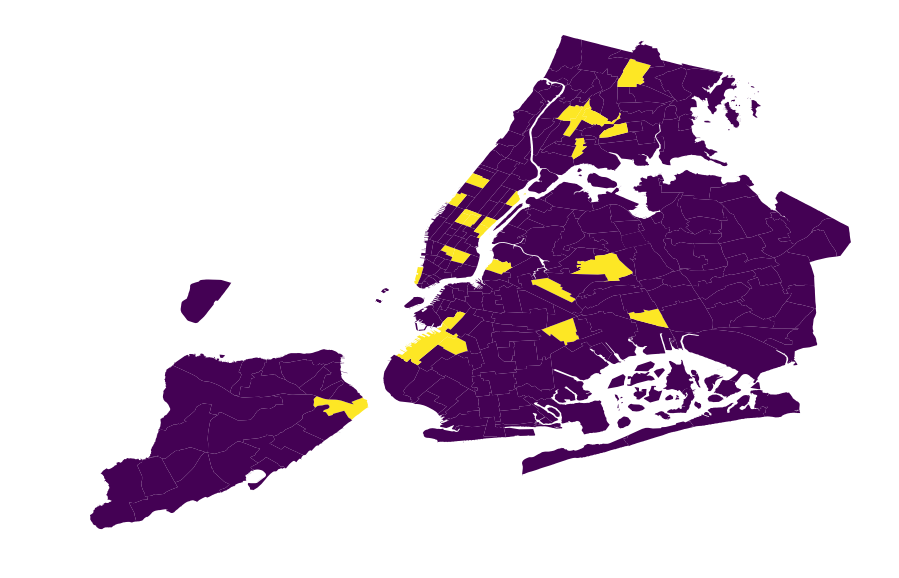

In [140]:
#plot the cluster labels
fig, ax = plt.subplots(1, figsize=(15, 10))
kmeans_geo.plot(column='cluster_label', cmap='viridis',linewidth=0.8, ax=ax)
ax.axis('off')

In [72]:
yelp.head()

,zone,LocationID,zip,review_cou,lng,lat,counts,tot_wk,tot_wknd,geometry
0,Newark Airport,1,10304.000000,54.500000,-74.181909,40.686651,2,0.0,0.0,"POLYGON ((-74.18445299999996 40.6949959999999,..."
1,Allerton/Pelham Gardens,3,10470.000000,25.000000,-73.848114,40.871216,1,0.0,0.0,POLYGON ((-73.84792614099985 40.87134223399991...
2,Alphabet City,4,10002.612903,166.354839,-73.979090,40.724829,31,21.0,21.0,POLYGON ((-73.97177410965318 40.72582128133705...
3,Arrochar/Fort Wadsworth,6,10314.000000,17.000000,-74.067627,40.592106,1,1.0,1.0,POLYGON ((-74.06367318899999 40.60219816599994...
4,Astoria,7,11338.291262,190.000000,-73.918941,40.762044,103,66.0,73.0,POLYGON ((-73.90413637799996 40.76752031699986...


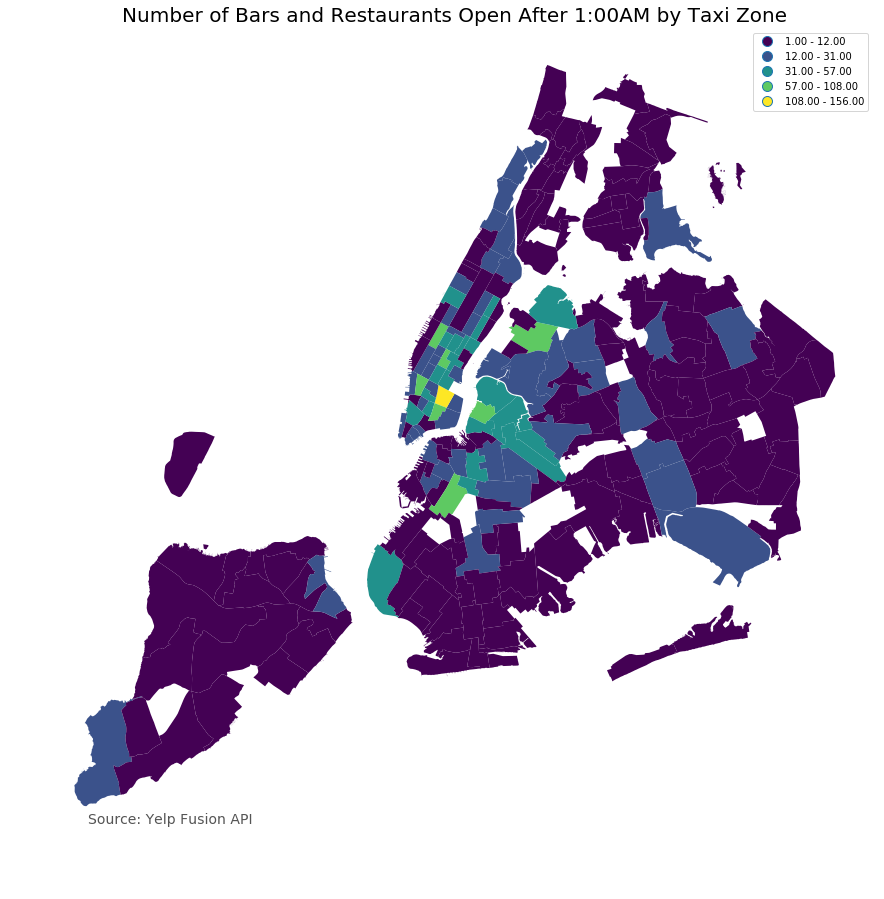

In [86]:
fig = plt.figure(figsize=(15,15)) #initialize figure
ax1 = fig.add_subplot(111) #initialize subplot


yelp.plot(column='counts', cmap='viridis',scheme='Fisher_Jenks',linewidth=0.8, ax=ax1,legend=True)

ax1.axis('off')
ax1.annotate('Source: Yelp Fusion API',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=14, color='#555555')
plt.title("Number of Bars and Restaurants Open After 1:00AM by Taxi Zone", fontsize=20)

plt.savefig('Number of Bars and Restaurants Open After 1:00AM by Taxi Zone.png')

In [87]:
seatgeek.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,night_even,all_events,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,0.0,0.0,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,0.0,0.0,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,0.0,0.0,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,54.0,54.0,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,0.0,0.0,"POLYGON ((935843.3104932606 144283.335850656, ..."


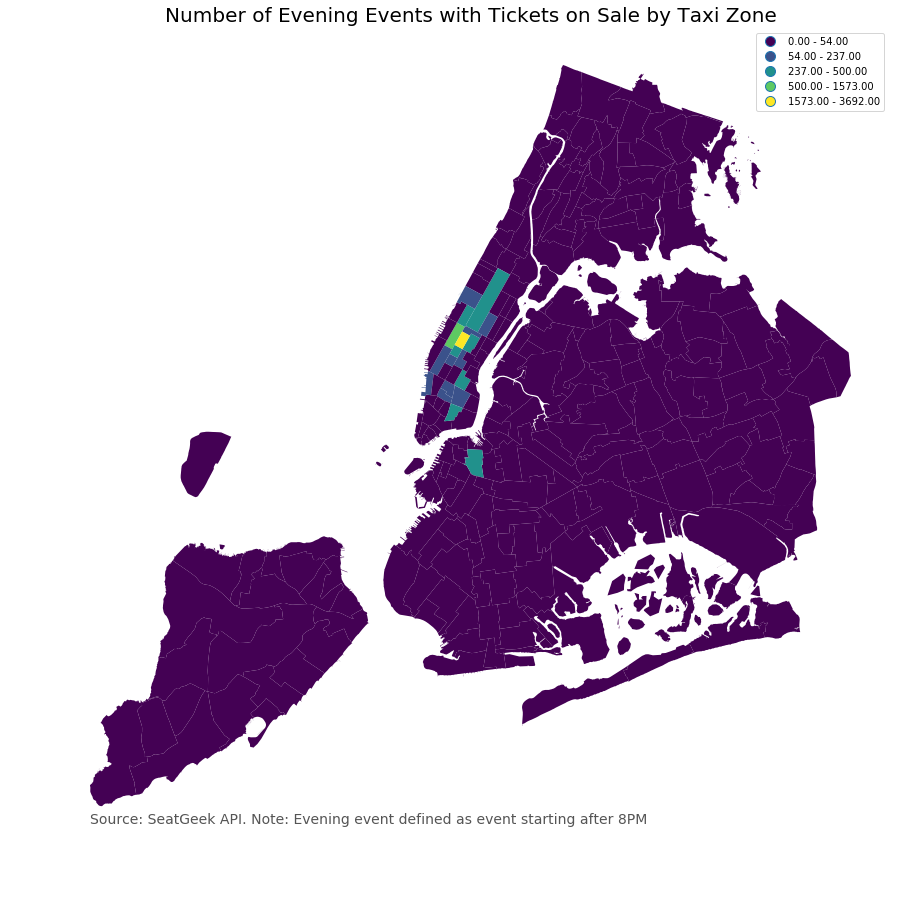

In [88]:
fig = plt.figure(figsize=(15,15)) #initialize figure
ax1 = fig.add_subplot(111) #initialize subplot


seatgeek.plot(column='night_even', cmap='viridis',scheme='Fisher_Jenks',linewidth=0.8, ax=ax1,legend=True)

ax1.axis('off')
ax1.annotate('Source: SeatGeek API. Note: Evening event defined as event starting after 8PM',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=14, color='#555555')
plt.title("Number of Evening Events with Tickets on Sale by Taxi Zone", fontsize=20)

plt.savefig('Number of Evening Events with Tickets on Sale by Taxi Zone.png')

In [91]:
taxi['DO_night'].fillna(0,inplace=True)

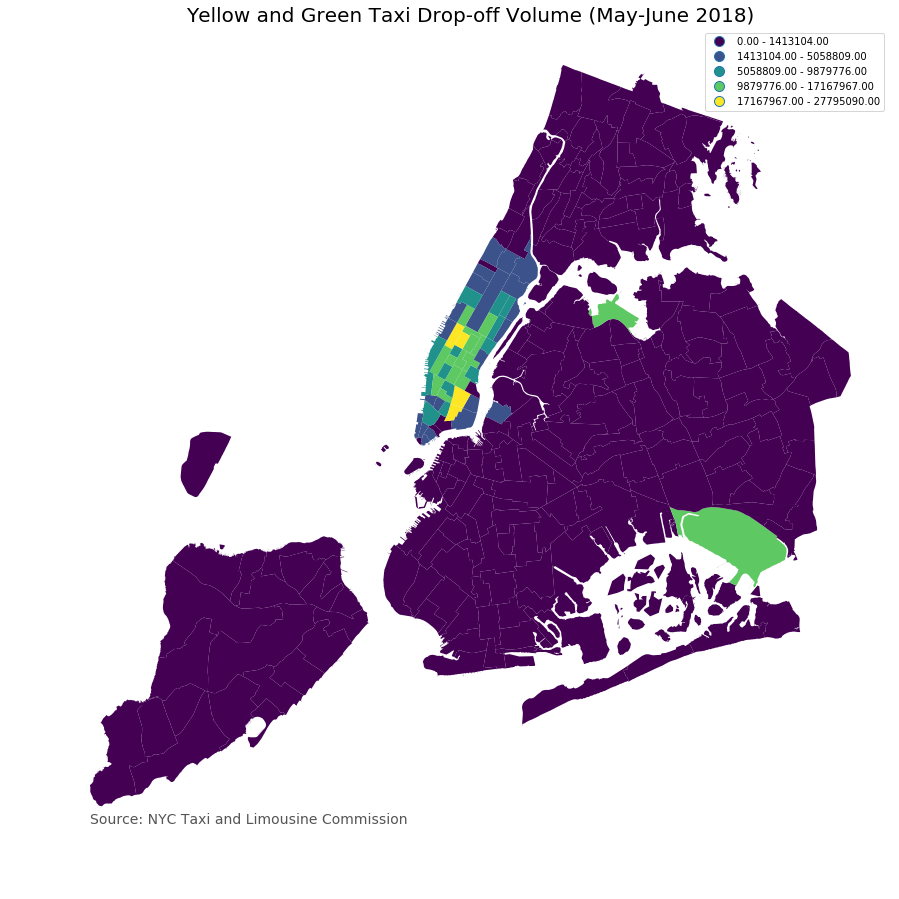

In [92]:
fig = plt.figure(figsize=(15,15)) #initialize figure
ax1 = fig.add_subplot(111) #initialize subplot


taxi.plot(column='DO_night', cmap='viridis',scheme='Fisher_Jenks',linewidth=0.8, ax=ax1,legend=True)

ax1.axis('off')
ax1.annotate('Source: NYC Taxi and Limousine Commission',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=14, color='#555555')
plt.title("Yellow and Green Taxi Drop-off Volume (May-June 2018)", fontsize=20)

plt.savefig('Yellow and Green Taxi Drop-off Volume (May-June 2018).png')

In [93]:
yelp_lisa.head()

,OBJECTID,SOURCE_ID,counts,Shape_Leng,Shape_Area,LMiIndex,LMiZScore,LMiPValue,COType,NNeighbors,geometry
0,1,0,2,0.116357,0.000782,0.000000,0.000000,0.000,None,0,POLYGON ((-74.18445299980607 40.69499600006543...
1,2,1,1,0.084341,0.000314,1.082198,0.918432,0.128,None,3,"POLYGON ((-73.84792614067879 40.8713422335573,..."
2,3,2,31,0.035600,0.000079,4.901815,5.088227,0.004,HH,2,"POLYGON ((-73.9717741097873 40.72582128122718,..."
3,4,3,1,0.129058,0.000405,1.230387,0.917010,0.152,None,4,POLYGON ((-74.06367318926624 40.60219816601261...
4,5,4,103,0.107417,0.000390,2.235667,0.196238,0.342,None,5,POLYGON ((-73.90413637839112 40.76752031740875...


In [111]:
yelp_lisa['COType'].fillna("Not Significant",inplace=True)

In [112]:
def transform_col(row):
    """Function to set up a column based on conditions"""
    if row['COType'] == 'Not Significant':
        return 0
    if row['COType'] == 'LL':
        return 1
    if row['COType'] == 'LH':
        return 2
    if row['COType'] == 'HL':
        return 3
    else:
        return 4

In [113]:
yelp_lisa['CAT']  = yelp_lisa.apply(lambda row: transform_col(row),axis=1) 

In [114]:
yelp_lisa.head(20)

,OBJECTID,SOURCE_ID,counts,Shape_Leng,Shape_Area,LMiIndex,LMiZScore,LMiPValue,COType,NNeighbors,geometry,CAT
0,1,0,2,0.116357,0.000782,0.000000,0.000000,0.000,Not Significant,0,POLYGON ((-74.18445299980607 40.69499600006543...,0
1,2,1,1,0.084341,0.000314,1.082198,0.918432,0.128,Not Significant,3,"POLYGON ((-73.84792614067879 40.8713422335573,...",0
2,3,2,31,0.035600,0.000079,4.901815,5.088227,0.004,HH,2,"POLYGON ((-73.9717741097873 40.72582128122718,...",4
3,4,3,1,0.129058,0.000405,1.230387,0.917010,0.152,Not Significant,4,POLYGON ((-74.06367318926624 40.60219816601261...,0
4,5,4,103,0.107417,0.000390,2.235667,0.196238,0.342,Not Significant,5,POLYGON ((-73.90413637839112 40.76752031740875...,0
5,6,5,7,0.099784,0.000338,0.776255,0.839287,0.200,Not Significant,5,POLYGON ((-73.78502434709588 40.76103651572265...,0
6,7,6,1,0.099839,0.000436,1.421676,1.059695,0.072,Not Significant,4,"POLYGON ((-73.78326624983754 40.6899942928024,...",0
7,8,7,4,0.072439,0.000203,0.201407,0.186275,0.470,Not Significant,3,POLYGON ((-74.00109809510099 40.60303462634698...,0
8,9,8,13,0.047261,0.000049,-0.136620,-0.754292,0.160,Not Significant,2,POLYGON ((-74.01244109298204 40.71905767257357...,0
9,10,9,37,0.136225,0.000664,-1.932888,-0.988101,0.084,Not Significant,4,POLYGON ((-74.03407329284812 40.64431393274185...,0


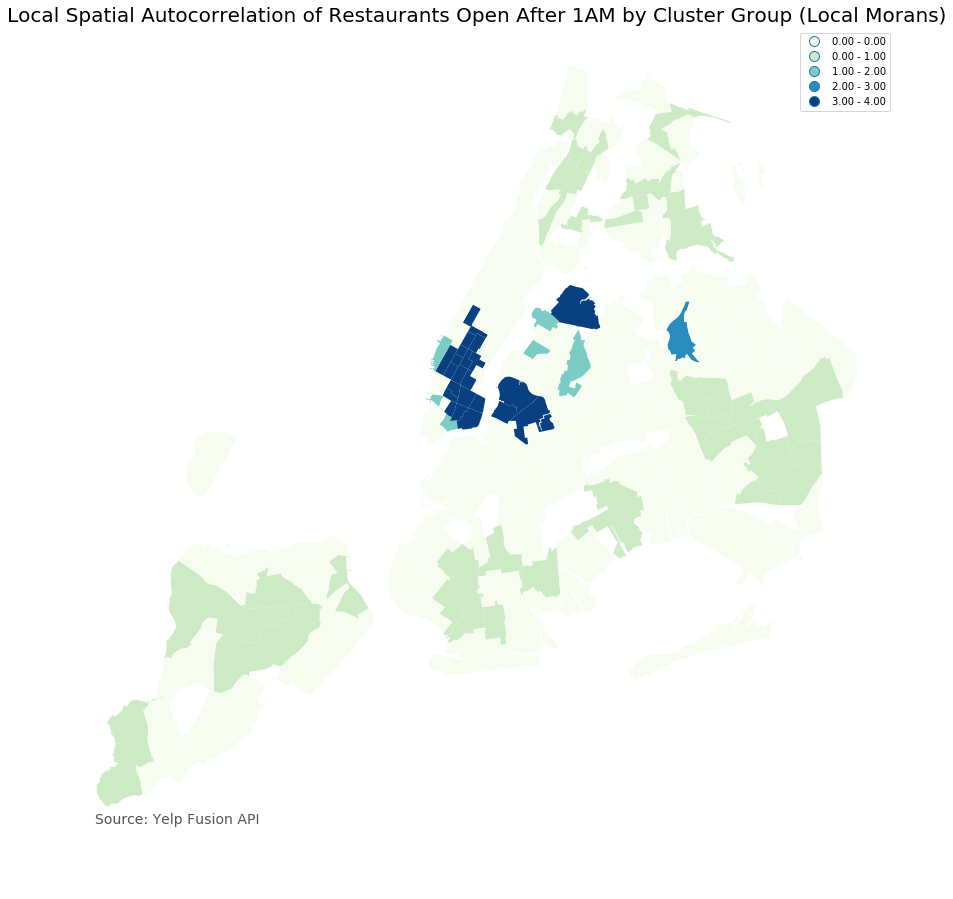

In [119]:
fig = plt.figure(figsize=(15,15)) #initialize figure
ax1 = fig.add_subplot(111) #initialize subplot


yelp_lisa.plot(column='CAT', cmap='GnBu',scheme='Fisher_Jenks',linewidth=0.8, ax=ax1,legend=True)

ax1.axis('off')
ax1.annotate('Source: Yelp Fusion API',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=14, color='#555555')
plt.title("Local Spatial Autocorrelation of Restaurants Open After 1AM by Cluster Group (Local Morans)", fontsize=20)

plt.savefig('Local Spatial Autocorrelation by Cluster Group (Local Morans).png')

In [152]:
taxi_lisa['COType'].fillna("Not Significant",inplace=True)
taxi_lisa['CAT']  = taxi_lisa.apply(lambda row: transform_col(row),axis=1) 

In [153]:
taxi_lisa.head()

,OBJECTID,SOURCE_ID,DO_night,Shape_Leng,Shape_Area,LMiIndex,LMiZScore,LMiPValue,COType,NNeighbors,geometry,CAT
0,1,0,814.0,37646.072282,7.903953e+07,0.000008,0.441631,0.100,Not Significant,1,"POLYGON ((933100.9182313383 192536.0857781768,...",0
1,2,1,363.0,267822.232105,1.439095e+08,0.000061,0.546031,0.348,Not Significant,12,"(POLYGON ((1033269.24348484 172126.0078320056,...",0
2,3,2,4532.0,25463.107589,3.168508e+07,0.000583,2.424998,0.002,LL,39,"POLYGON ((1026308.769544929 256767.69747217, 1...",1
3,4,3,1761922.0,11304.103443,8.023733e+06,-0.000252,-9.793233,0.002,LH,83,"POLYGON ((992073.4669526666 203714.0758893341,...",2
4,5,4,10.0,29692.078842,5.041488e+07,0.000129,1.137114,0.002,LL,9,"POLYGON ((935843.3103843331 144283.3358271718,...",1


In [147]:
taxi_lisa['CAT'].unique()

array([4, 1, 2, 3])

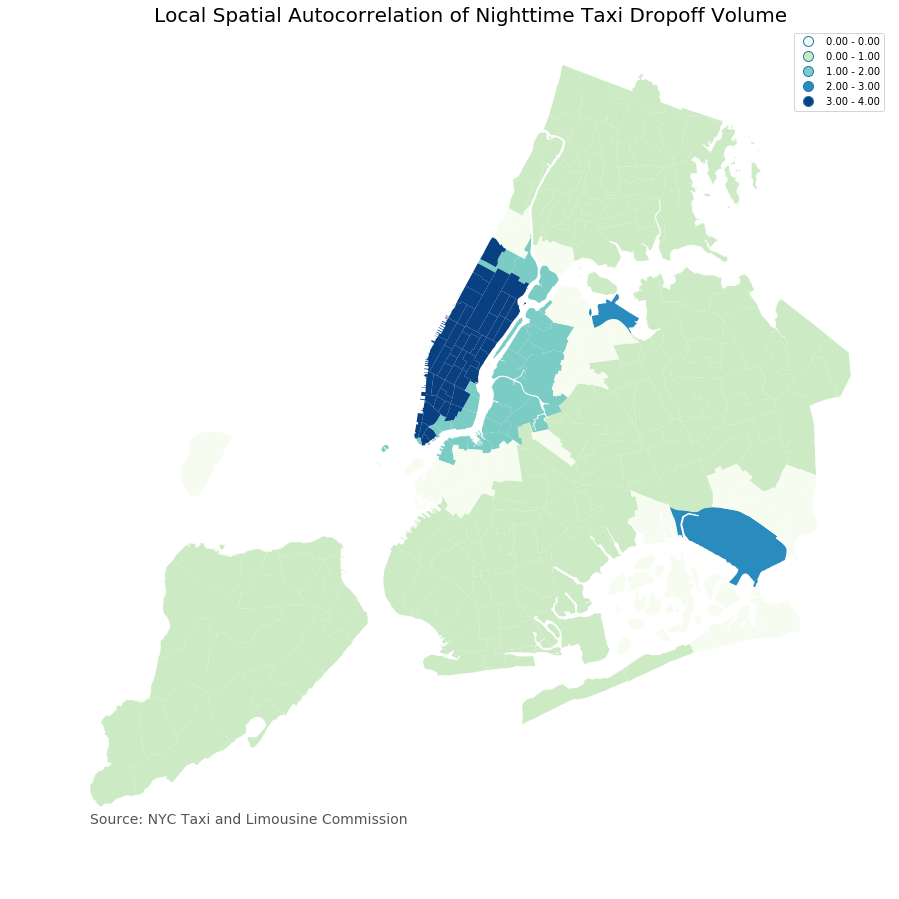

In [155]:
fig = plt.figure(figsize=(15,15)) #initialize figure
ax1 = fig.add_subplot(111) #initialize subplot


taxi_lisa.plot(column='CAT', cmap='GnBu',scheme='Fisher_jenks',linewidth=0.8, ax=ax1,legend=True)

ax1.axis('off')
ax1.annotate('Source: NYC Taxi and Limousine Commission',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=14, color='#555555')
plt.title("Local Spatial Autocorrelation of Nighttime Taxi Dropoff Volume", fontsize=20)

plt.savefig('Local Spatial Autocorrelation by Cluster Group for Nighttime Taxi Dropoffs (Local Morans).png')

In [159]:
seatgeek_lisa['COType'].fillna("Not Significant",inplace=True)
seatgeek_lisa['CAT']  = seatgeek_lisa.apply(lambda row: transform_col(row),axis=1) 

In [162]:
seatgeek_lisa['CAT'].unique()

array([0, 4, 3, 2])

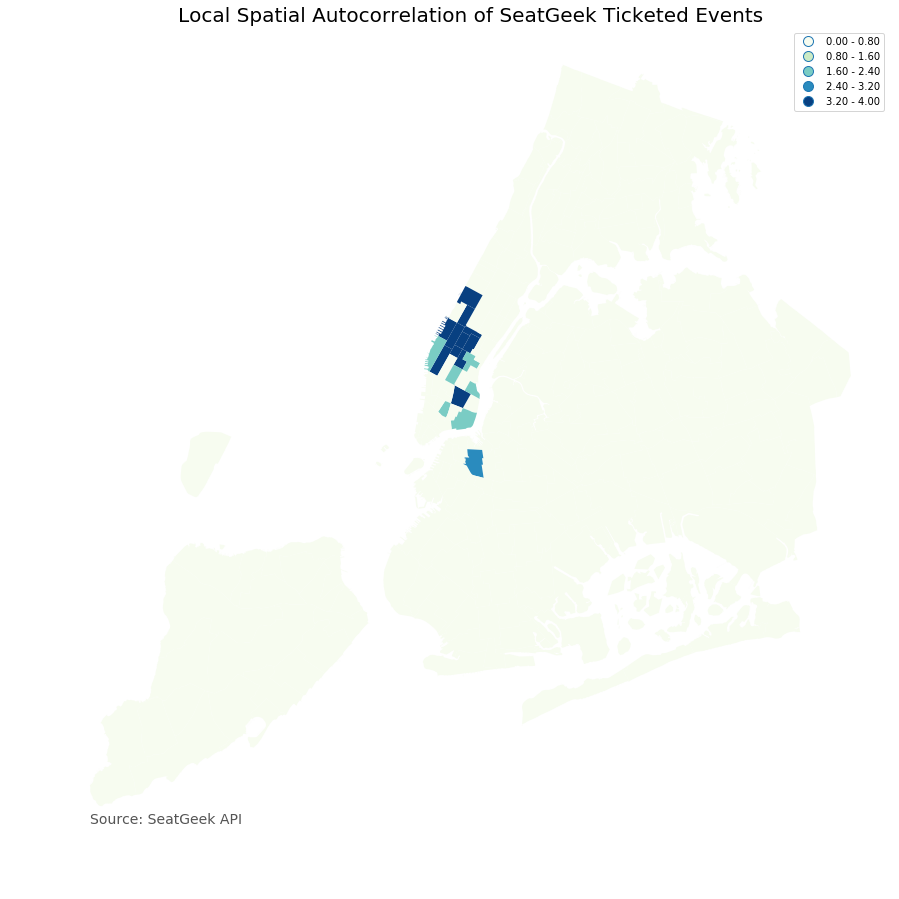

In [163]:
fig = plt.figure(figsize=(15,15)) #initialize figure
ax1 = fig.add_subplot(111) #initialize subplot


seatgeek_lisa.plot(column='CAT', cmap='GnBu',scheme='Equal_interval',linewidth=0.8, ax=ax1,legend=True)

ax1.axis('off')
ax1.annotate('Source: SeatGeek API',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=14, color='#555555')
plt.title("Local Spatial Autocorrelation of SeatGeek Ticketed Events", fontsize=20)

plt.savefig('Local Spatial Autocorrelation by Cluster Group for SeatGeek Events (Local Morans).png')

In [3]:
seatgeek.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,night_even,all_events,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,0.0,0.0,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,0.0,0.0,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,0.0,0.0,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,54.0,54.0,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,0.0,0.0,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [6]:
seatgeek[seatgeek['night_even'] > 0].count()

OBJECTID      39
Shape_Leng    39
Shape_Area    39
zone          39
LocationID    39
borough       39
night_even    39
all_events    39
geometry      39
dtype: int64